# Mount/Imports

In [1]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Changing directory to Session 2 project folder
% cd /content/gdrive/My Drive/EVA 7/Session 2/

[Errno 2] No such file or directory: '/content/gdrive/My Drive/EVA 7/Session 2/'
/content


In [3]:
# Lists the contents of this folder
! ls 

gdrive	sample_data


In [4]:
# Imports 
import numpy as np 
import matplotlib.pyplot as plt

"""
Torch is an open-source machine learning library, a scientific computing framework, 
and a script language based on the Lua programming language. 
It provides a wide range of algorithms for deep learning.
"""

import torch                                                                    
import torchvision                                                              # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms                                     # for image transforms

# linewidth – The number of characters per line for the purpose of inserting line breaks (default = 80)
torch.set_printoptions(linewidth=120)

# Dataset

In [5]:
from torchvision import datasets                                                # Access to benchmarking datasets

train_set = datasets.MNIST('./data', train=True, download=True,                 # Downloading the training dataset in ./data folder
                    transform=transforms.Compose([                              # and transforming the images to tensors and normalizing with
                        transforms.ToTensor(),                                  # mean and std of the entire dataset
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test_set = datasets.MNIST('./data', train=False, download=True,                 # Downloading the test dataset in ./data folder 
                    transform=transforms.Compose([                              # and transforming the images to tensors and normalizing with
                        transforms.ToTensor(),                                  # mean and std of the entire dataset
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
def num_to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def categorical_to_num(y):
  """ Decodes a 1-hot encoding """
  return np.argmax(y)

In [7]:
# Dataset is there to be able to interact with DataLoader
from torch.utils.data import Dataset                                            

class mnist_data(Dataset):
  '''
  mnist_data class to create an iteratable on our custom mnist dataset:
  where data = (image, random number) and labels = (image number, sum of random number and image number)
  Attributes:
    mnist: mnist data object
  Methods:
    len: returns length of the dataset 
    getitem: custom getitem method returns data and labels
  '''
  def __init__(self, d):
    self.mnist = d                                                              # Initialize with mnist data object

  def __getitem__(self, index):                                                 
    image, label = self.mnist[index]                                              
    n = np.random.randint(low=0, high=10)                                       # generate a random number from 0 to 9 using randint              
    s = n+label                                                                 # sum of the image number and the random number n
    number = torch.tensor(num_to_categorical(n, 10))                            # 1-hot encoding of random number   
    return (image, number), (torch.tensor(label), torch.tensor(s))              # (input), (output) to network      

  def __len__(self):                                                            # Return the length of the dataset
    return len(self.mnist)

In [8]:
train_set_custom = mnist_data(train_set)                                        # custom train_set from mnist_data class
test_set_custom = mnist_data(test_set)                                          # custom test_set from mnist_data class

In [9]:
use_cuda = torch.cuda.is_available()                                            # use gpu if available
device = torch.device("cuda" if use_cuda else "cpu")                            # assigning gpu to variable device

# If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, 
# you can speed up the host to device transfer by enabling pin_memory.
# num_workers attribute tells the data loader instance how many sub-processes to use for data loading
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}             
batch_size = 100                                                                # set size of batch                                    

train_loader = torch.utils.data.DataLoader(                                     # For iterating through our dataset in batches      
    train_set_custom,
    batch_size = batch_size,  
    shuffle=True,                                                               # Shuffle the data points randomly
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    test_set_custom,
    batch_size = batch_size,
    shuffle=True, 
    **kwargs
)

# Visualization

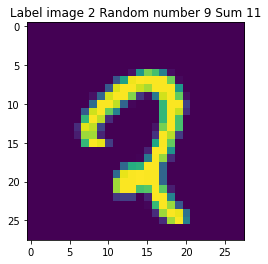

In [10]:
x = np.random.randint(low=0, high=len(train_set_custom))                        # Pick a random datapoint

sample = train_set_custom[x]
input, labels = sample 

image, random_number = input 
label_image, label_sum = labels

plt.imshow(image.squeeze())                                                     # Plot 2-d image tensor
plt.title("Label image " + str(label_image.numpy()) + " Random number " + str(categorical_to_num(random_number.numpy())) + " Sum " + str(label_sum.numpy()))
plt.show()

# Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
class Network(nn.Module):
  """
  Network class that inherits nn.Module
  Methods: 
    forward: forward pass the layers of the network to return output
  """

  def __init__(self):
    
    super().__init__()

    # In comments we will be writing the input (s, s, channels), kernel (s, s, channels, no. of kernels), 
    # output (x, y, channels), receptive field (s, s, channels)

    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)         # (28, 28, 1)   --> (3, 3, 1, 32)     --> (28, 28, 32)  [R.F. (3, 3, 1)]
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        # (28, 28, 32)  --> (3, 3, 32, 64)    --> (28, 28, 64)  [R.F. (5, 5, 32)]
    self.pool1 = nn.MaxPool2d(2, 2)                     # (28, 28, 64)  --> (2, 2)            --> (14, 14, 64)  [R.F. (10, 10, 64)]
    
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)       # (14, 14, 64)  --> (3, 3, 64, 128)   --> (14, 14, 128) [R.F. (12, 12, 64)]
    self.conv4 = nn.Conv2d(128, 256, 3, padding=1)      # (14, 14, 128) --> (3, 3, 128, 256)  --> (14, 14, 256) [R.F. (14, 14, 128)]
    self.pool2 = nn.MaxPool2d(2, 2)                     # (14, 14, 256) --> (2, 2)            --> (7, 7, 256)   [R.F. (28, 28, 256)]
    
    self.conv5 = nn.Conv2d(256, 512, 3)                 # (7, 7, 256)   --> (3, 3, 256, 512)  --> (5, 5, 512)   [R.F. (30, 30, 256)]
    self.conv6 = nn.Conv2d(512, 1024, 3)                # (5, 5, 512)   --> (3, 3, 512, 1024) --> (3, 3, 1024)  [R.F. (32, 32, 512)]
    self.conv7 = nn.Conv2d(1024, 10, 3)                 # (3, 3, 1024)  --> (3, 3, 1024, 10)  --> (1, 1, 10)    [R.F. (34, 34, 1024)]
    
    self.fc1 = nn.Linear(in_features=20, out_features=100)      # We add a large number of neurons at this stage for the network to understand addition
    self.fc2 = nn.Linear(in_features=100, out_features=50)      # FC layer

    self.out1 = nn.Linear(in_features=50, out_features=10)      # Output in 1-hot encoding for the image label
    self.out2 = nn.Linear(in_features=50, out_features=19)      # Output in 1-hot encoding for the sum


  def forward(self, x, random_num):

    """
    Forward pass for the network
    Inputs: 
      x: Image 
      random_num: 1-hot encoding of a random number 
    Outputs: 
      x1: 1-hot encoding of prediction of image number 
      x2: 1-hot encoding of prediction of sum 
    """

    # first block
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))

    # second block
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

    # third block 
    x = self.conv7(F.relu(self.conv6(F.relu(self.conv5(x)))))

    # FC 
    x, random_num = x.reshape(-1, 10), random_num.reshape(-1, 10)               # At this layer, we concantenate the two inputs
    x = torch.cat((x, random_num), dim=1)
    
    x = self.fc2(F.relu(self.fc1(x)))

    x1, x2 = self.out1(x), self.out2(x)
    x1, x2 = x1.view(-1, 10), x2.view(-1, 19)

    return F.log_softmax(x1, dim=0), F.log_softmax(x2, dim=0)


In [13]:
# Create an instance of our network and use it on device 
model = Network().to(device)                                  

In [14]:
# printing all named parameters in the network
for name, param in model.named_parameters():
  print(name, '\t\t', param.shape) 

conv1.weight 		 torch.Size([32, 1, 3, 3])
conv1.bias 		 torch.Size([32])
conv2.weight 		 torch.Size([64, 32, 3, 3])
conv2.bias 		 torch.Size([64])
conv3.weight 		 torch.Size([128, 64, 3, 3])
conv3.bias 		 torch.Size([128])
conv4.weight 		 torch.Size([256, 128, 3, 3])
conv4.bias 		 torch.Size([256])
conv5.weight 		 torch.Size([512, 256, 3, 3])
conv5.bias 		 torch.Size([512])
conv6.weight 		 torch.Size([1024, 512, 3, 3])
conv6.bias 		 torch.Size([1024])
conv7.weight 		 torch.Size([10, 1024, 3, 3])
conv7.bias 		 torch.Size([10])
fc1.weight 		 torch.Size([100, 20])
fc1.bias 		 torch.Size([100])
fc2.weight 		 torch.Size([50, 100])
fc2.bias 		 torch.Size([50])
out1.weight 		 torch.Size([10, 50])
out1.bias 		 torch.Size([10])
out2.weight 		 torch.Size([19, 50])
out2.bias 		 torch.Size([19])


In [15]:
from torchsummary import summary

# show model summary (layers, output shapes and number of paramaters)
summary(model, [(1, 28, 28), (1, 1, 10)]) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
           Linear-10                  [-1, 100]           2,100
           Linear-11                   [-1, 50]           5,050
           Linear-12                   [-1, 10]             510
           Linear-13                   [-1, 19]             969
Total params: 6,388,415
Trainable param

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training

In [16]:
def get_num_correct(preds, labels):

  """
  Returns number of correct predictions given 
  Inputs: 
    preds: tensor of predictions
    labels: tensor of labels
  """

  a = preds.argmax(dim=1)
  b = labels 

  return torch.sum((a==b)).item()

In [17]:
# Import tqdm for creating progress bar
from tqdm import tqdm

def train(model, device, train_loader, optimizer):

    model.train()                                                               # Tells model it's training
    pbar = tqdm(train_loader)

    for batch_idx, (data, labels) in enumerate(pbar):                           # for loop for batches

      images, random_numbers = data 
      image_labels, sum_labels = labels 

      images, random_numbers = images.to(device), random_numbers.to(device)     # send data to device
      image_labels, sum_labels = image_labels.to(device), sum_labels.to(device) # send labels to device

      optimizer.zero_grad()                                                     # make gradients zero 

      output = model(images, random_numbers)                                    # forward pass once to get outputs
      preds_images, preds_sums = output   

      loss1 = F.cross_entropy(preds_images, image_labels)                       # get crossentropy loss on image labels
      loss2 = F.cross_entropy(preds_sums, sum_labels)                           # get crossentropy loss of sum labels
      loss = loss1 + loss2 
      loss.backward()                                                           # back propagation 

      optimizer.step()                                                          # change weights of the network
      
      pbar.set_description(desc= f'Train loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
  
  model.eval()                                                                  # Tells model it's evaluating

  test_loss = 0                                                                 # initalize test loss, # of correct labels = 0
  correct_image_label, correct_sum_label = 0, 0
  
  with torch.no_grad():                                                         # Without any change in gradients
    
    for data, labels in test_loader:
      
      images, random_numbers = data 
      image_labels, sum_labels = labels 

      images, random_numbers = images.to(device), random_numbers.to(device)     # send data to device
      image_labels, sum_labels = image_labels.to(device), sum_labels.to(device) # send labels to device

      output = model(images, random_numbers)                                    # forward pass once to get outputs                             
      preds_images, preds_sums = output
   
      loss1 = F.cross_entropy(preds_images, image_labels) 
      loss2 = F.cross_entropy(preds_sums, sum_labels)
      loss = loss1 + loss2 

      test_loss += loss.item()                                                  # Calculate test loss
        
      correct_image_label += get_num_correct(preds_images, image_labels)        # Get number of correct predictions 
      correct_sum_label += get_num_correct(preds_sums, sum_labels)              # for images and sum

    print('\nTest set: Average loss: {:.4f}, Accuracy image labels: {}/{} ({:.0f}%), Accuracy sum labels: {}/{} ({:.0f}%)'.format(
        test_loss / len(test_loader.dataset), correct_image_label, len(test_loader.dataset),
        100. * correct_image_label / len(test_loader.dataset), correct_sum_label, len(test_loader.dataset),
        100. * correct_sum_label / len(test_loader.dataset)))

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)                # Set optimizer to Stocastic gradient descent

for epoch in range(0, 5):                                                       # for loop for each epoch of training 
    train(model, device, train_loader, optimizer)                               # train
    test(model, device, test_loader)                                            # test

Train loss=2.001474142074585 batch_id=599: 100%|██████████| 600/600 [00:46<00:00, 12.85it/s]



Test set: Average loss: 0.0199, Accuracy image labels: 9653/10000 (97%), Accuracy sum labels: 2631/10000 (26%)


Train loss=1.315924048423767 batch_id=599: 100%|██████████| 600/600 [00:47<00:00, 12.77it/s]



Test set: Average loss: 0.0120, Accuracy image labels: 9873/10000 (99%), Accuracy sum labels: 6109/10000 (61%)


Train loss=0.335256427526474 batch_id=599: 100%|██████████| 600/600 [00:47<00:00, 12.76it/s]



Test set: Average loss: 0.0048, Accuracy image labels: 9920/10000 (99%), Accuracy sum labels: 8989/10000 (90%)


Train loss=0.31646761298179626 batch_id=599: 100%|██████████| 600/600 [00:46<00:00, 12.78it/s]



Test set: Average loss: 0.0021, Accuracy image labels: 9914/10000 (99%), Accuracy sum labels: 9616/10000 (96%)


Train loss=0.10507485270500183 batch_id=599: 100%|██████████| 600/600 [00:46<00:00, 12.77it/s]



Test set: Average loss: 0.0012, Accuracy image labels: 9928/10000 (99%), Accuracy sum labels: 9738/10000 (97%)
